In [1]:
import numpy as np

import torch
from torch import nn
from ising_nn import IsingNNModel, IsingDataset

from matplotlib import pyplot as plt

In [11]:
# Load the ML models into modles list
Ns = [10, 16, 25]
models = [IsingNNModel(N) for N in Ns]
for model in models:
    model.load_state_dict(torch.load(f"ising_nn_models/N_{model.N}_J_1_B_0.pth"))
    model.eval()

In [2]:
def transform(config : np.ndarray):
    """Function that transforms config from 1D to 2D and vice-versa"""
    if config.ndim == 1:
        N = int(np.sqrt(len(config)))
        return config.reshape((N, N))
    else:
        return config.flatten()

def protocol_identity(config : np.ndarray):
    return config

def protocol_single_row(config : np.ndarray):
    return np.roll(config, 1, axis=0)

def protocol_single_col(config : np.ndarray):
    return np.roll(config, 1, axis=1)

def protocol_single_row_col(config : np.ndarray):
    return np.roll(np.roll(config, 1, axis=0), 1, axis=1)

def protocol_random_row(config : np.ndarray):
    shift = np.random.randint(0, config.shape[0])
    return np.roll(config, shift, axis=0)

def protocol_random_col(config : np.ndarray):
    shift = np.random.randint(0, config.shape[1])
    return np.roll(config, shift, axis=1)

def protocol_random_row_col(config : np.ndarray):
    shift_row, shift_col = np.random.randint(0, config.shape[0]), np.random.randint(0, config.shape[1])
    return np.roll(np.roll(config, shift_row, axis=0), shift_col, axis=1)

def shift_config(config : torch.tensor, protocol : callable):
    config = transform(config.numpy())
    config = transform(protocol(config))
    return torch.tensor(config, dtype=torch.float32)

# Before special training

In [19]:
protocols = {"Single row": protocol_single_row, "Single column": protocol_single_col, "Single row, col": protocol_single_row_col, 
            "Random row": protocol_random_row, "Random row, col": protocol_random_row_col, "Random column": protocol_random_col}
results = {N : {} for N in Ns}

total_jobs = len(protocols) * len(models)
done = 0

with torch.no_grad():
    for model in models:
        dataset = IsingDataset(train=False, N=model.N, J=1, B=0)
        for protocol_name, protocol in protocols.items():
            results[model.N][protocol_name] = np.empty((len(dataset), 2))
            for i, entry in enumerate(dataset):
                config, label = entry
                temp_pred_before = model(config)[0].item()
                config = shift_config(config, protocol)
                temp_pred_after = model(config)[0].item()
                results[model.N][protocol_name][i] = [temp_pred_before, temp_pred_after]
            done += 1
            print(f"Progress: {done/total_jobs*100:0.2f}%", end="\r")
                

------------- Test report for N=10 -------------
Protocol		Mean squared difference

Single row		0.02393006869957337
Single column		0.02460292038150755
Single row, col		0.02404293691973491
Random row		0.022086208064669724
Random row, col		0.024433404819216856
Random column		0.02195311599479088

------------- Test report for N=16 -------------
Protocol		Mean squared difference

Single row		0.03615312568218491
Single column		0.03711559569209818
Single row, col		0.03667754685068023
Random row		0.035569138496927194
Random row, col		0.03748175100365472
Random column		0.034735219020153474

------------- Test report for N=25 -------------
Protocol		Mean squared difference

Single row		0.04251730522614438
Single column		0.04338418834297591
Single row, col		0.044109621368453006
Random row		0.04405628410592058
Random row, col		0.044816475005702315
Random column		0.04517239870270031



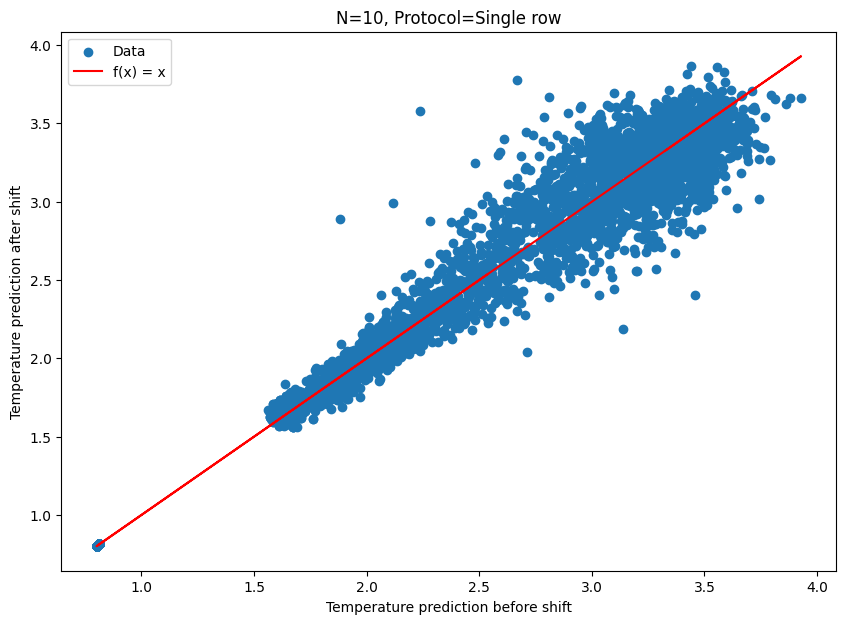

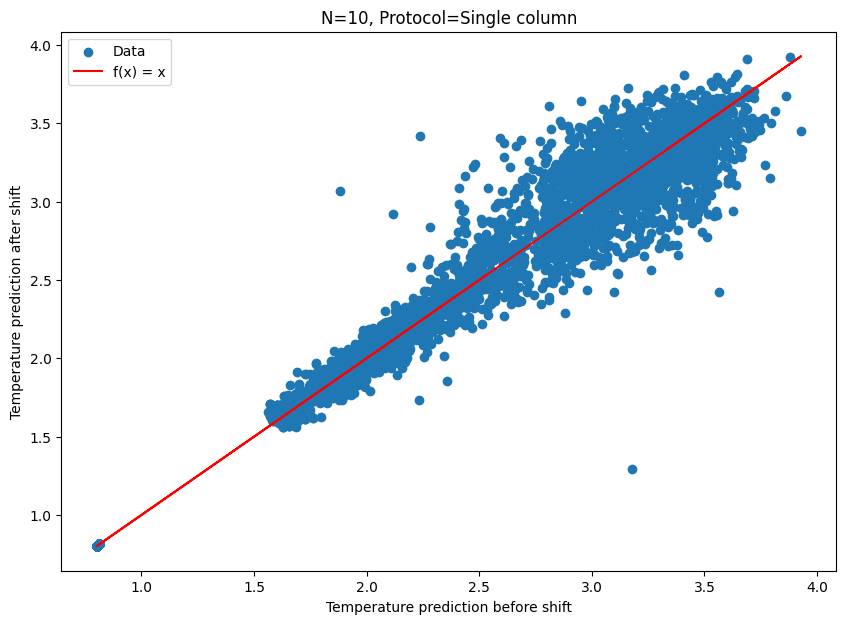

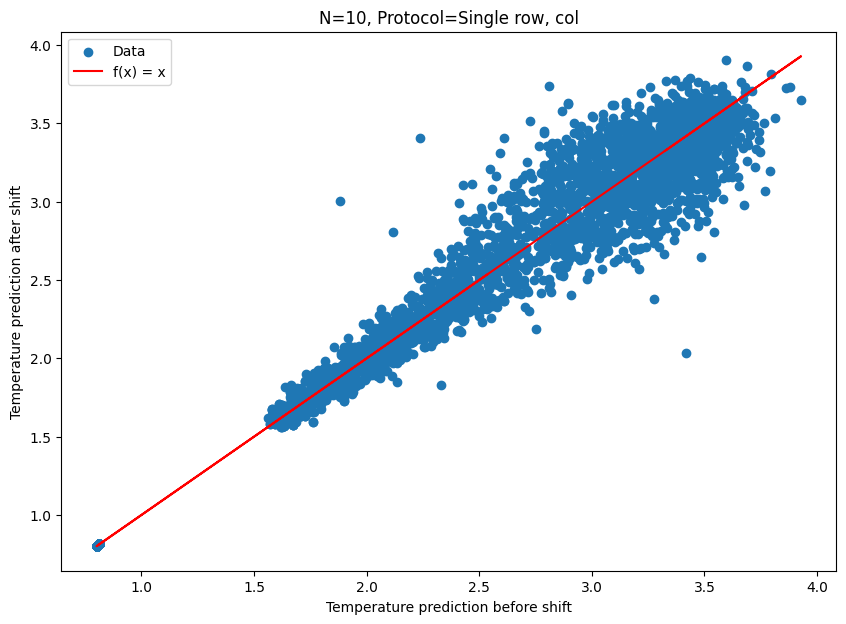

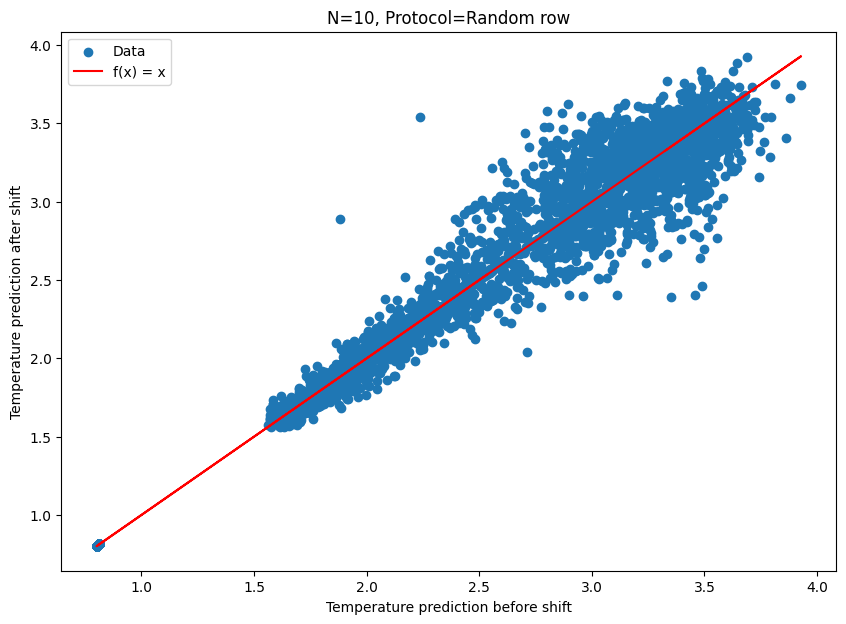

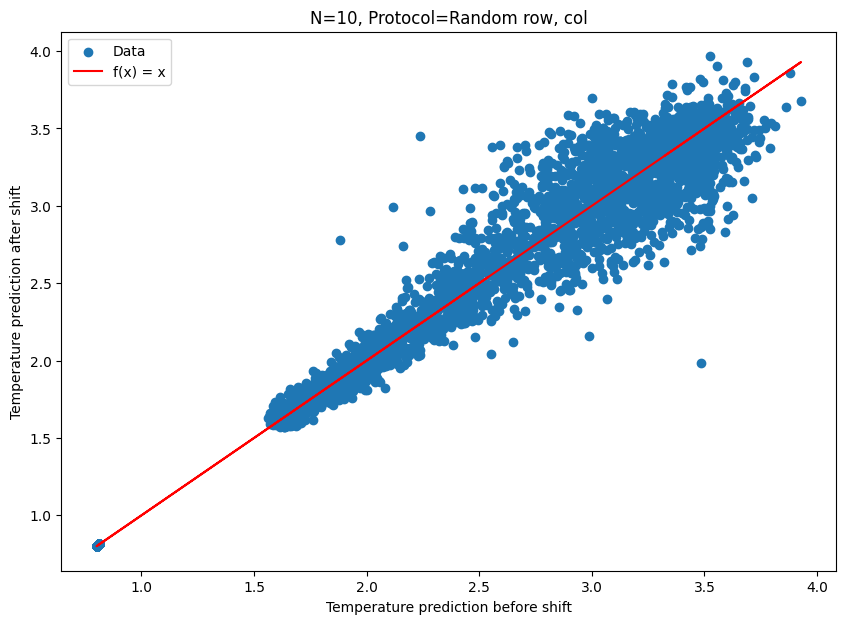

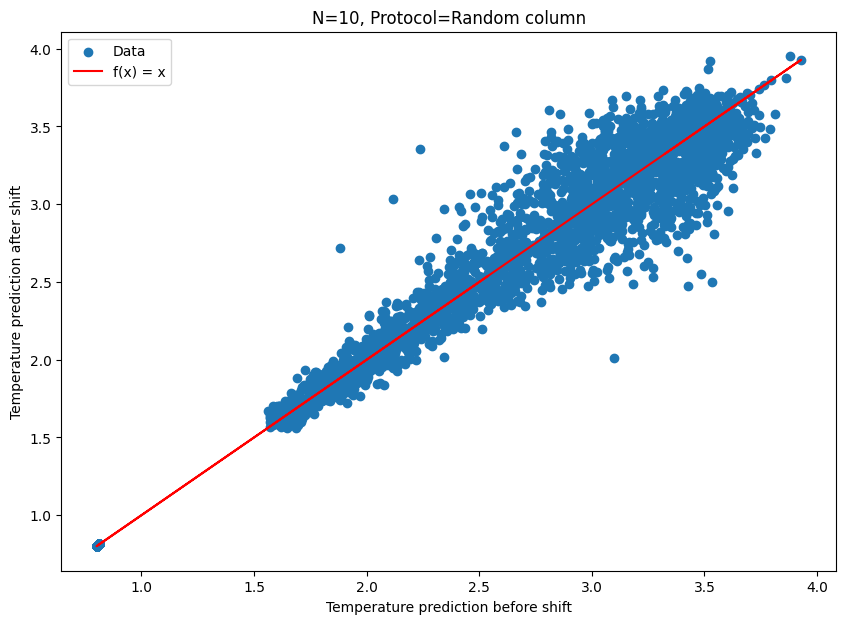

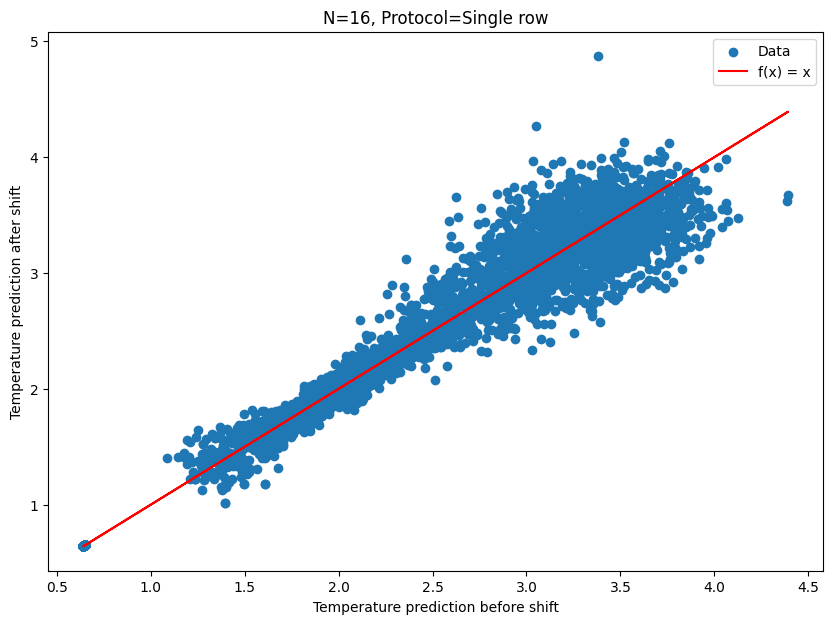

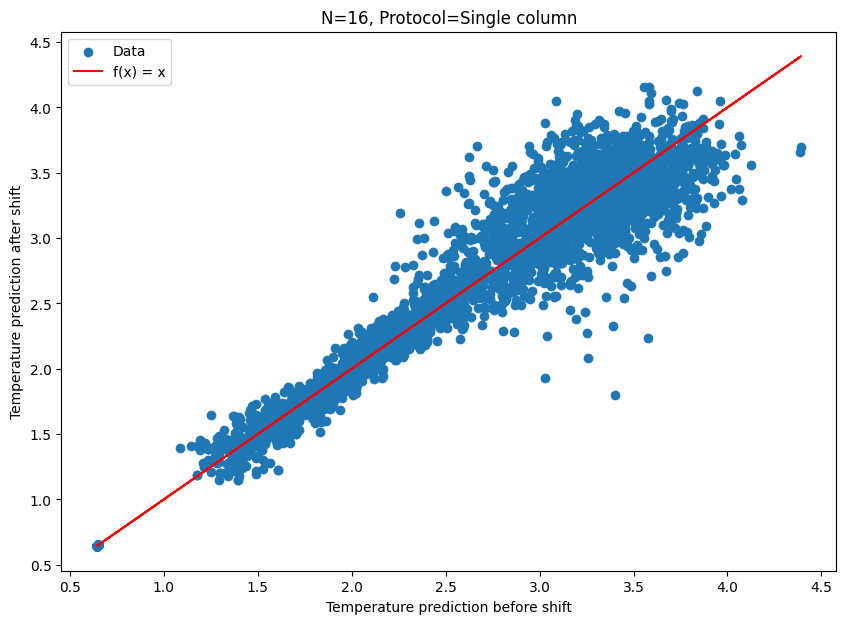

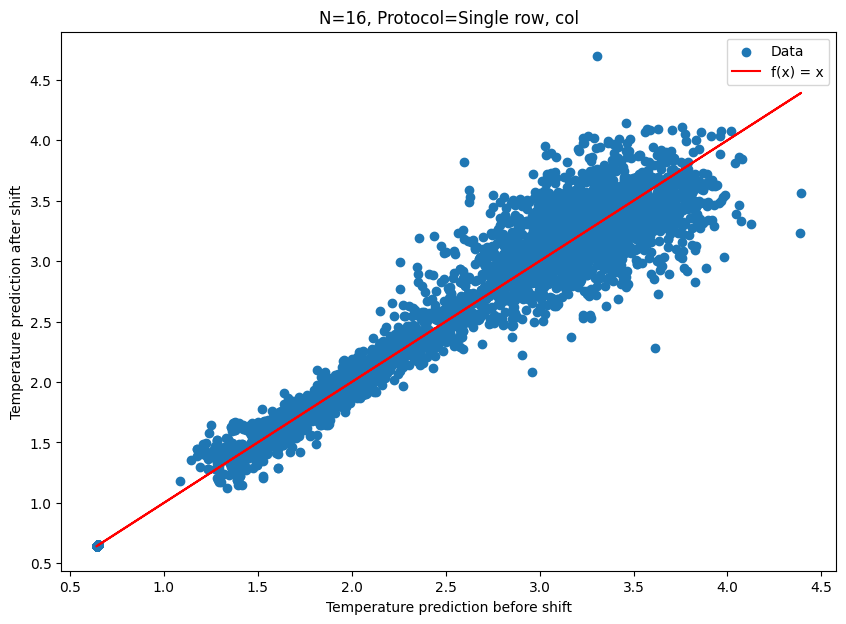

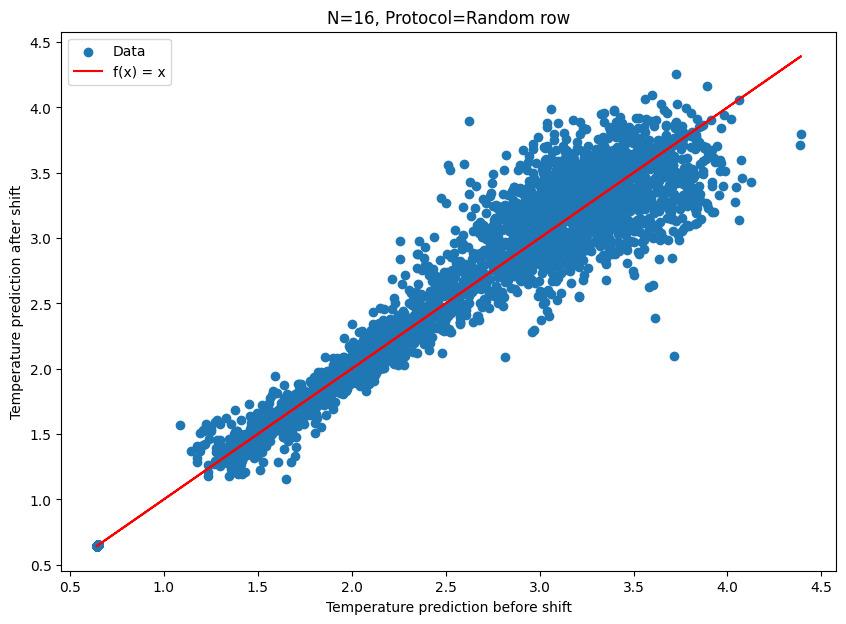

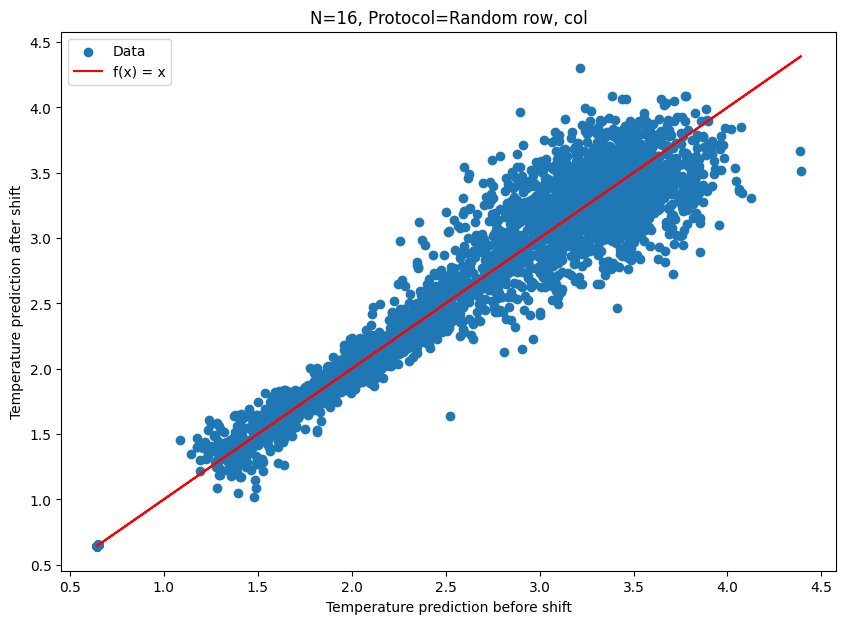

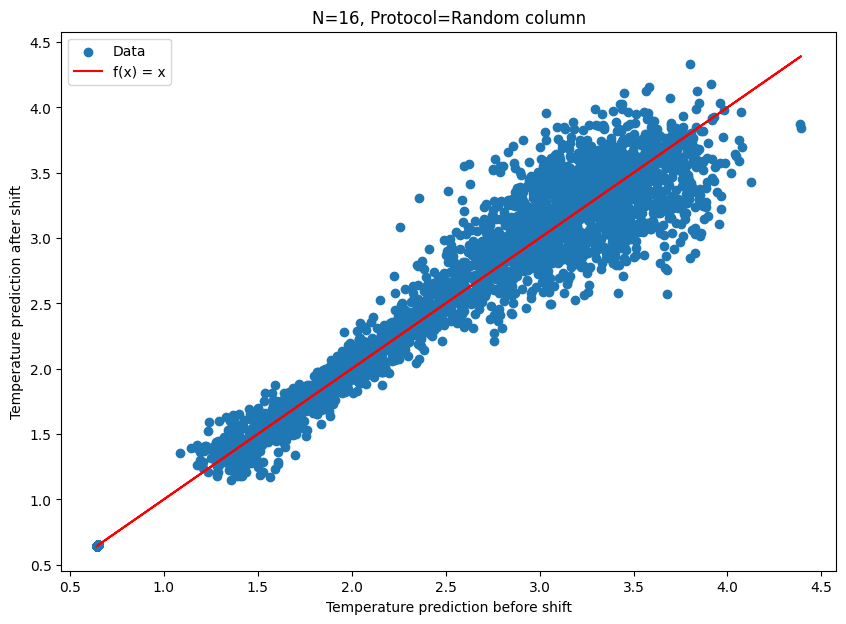

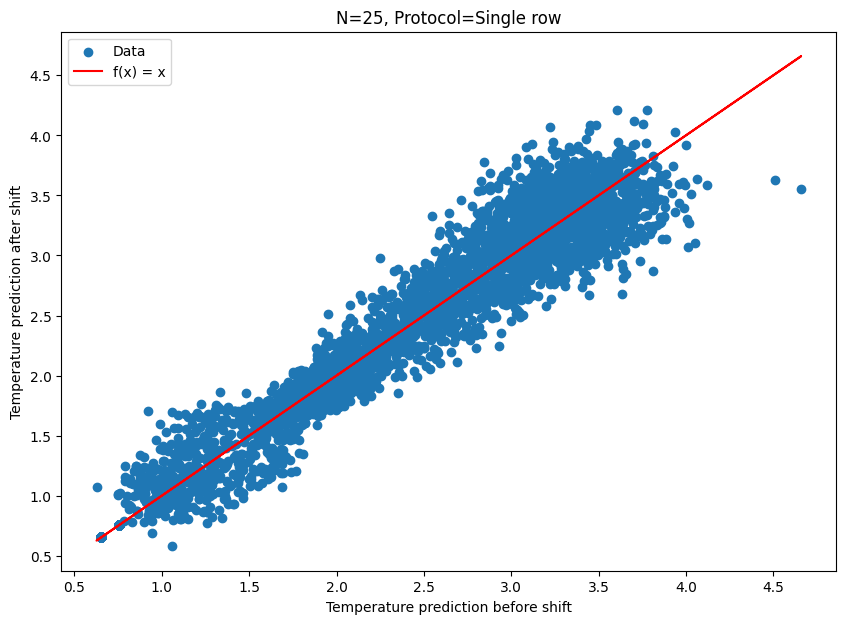

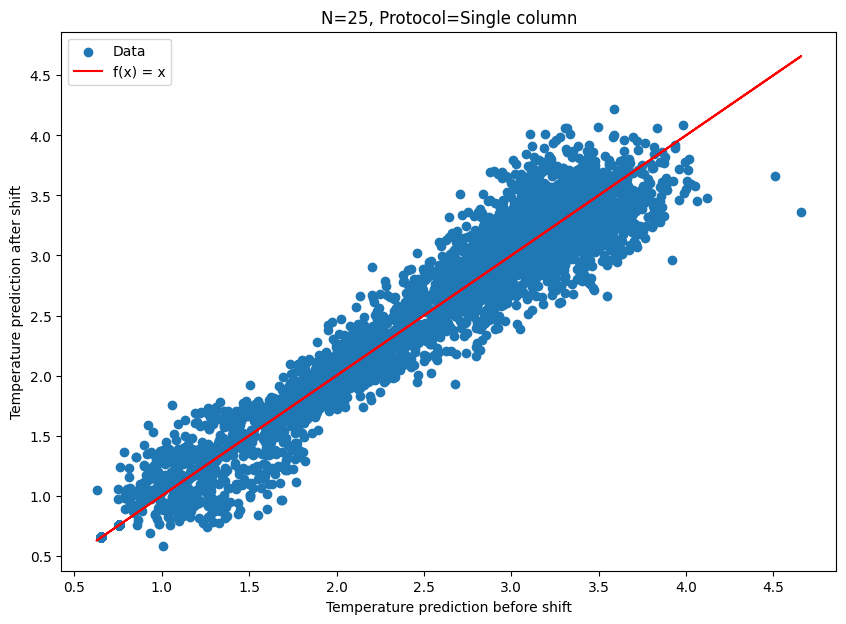

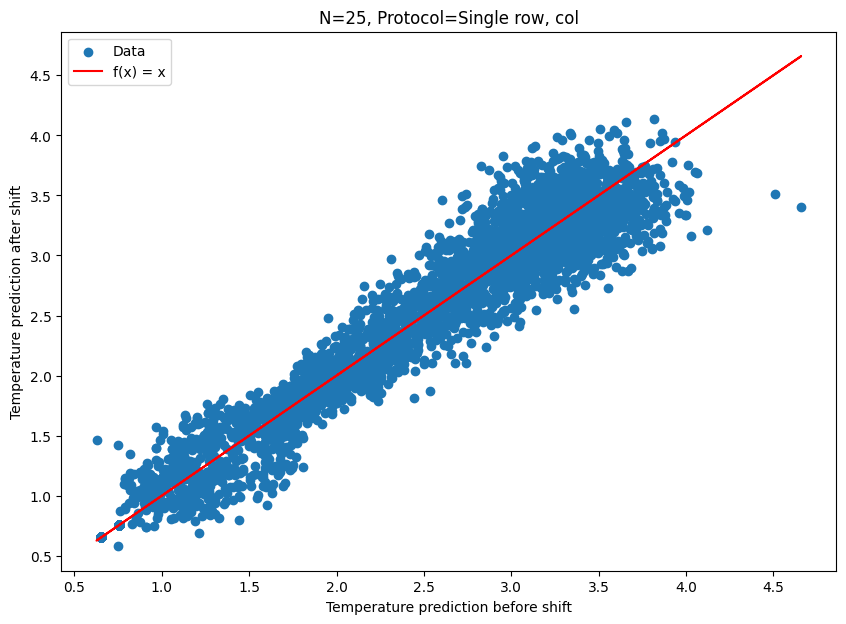

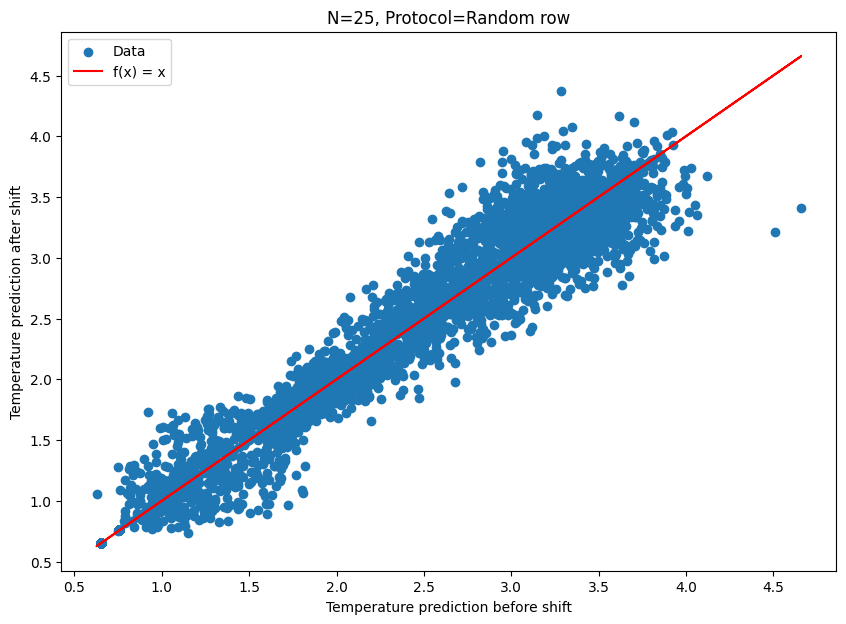

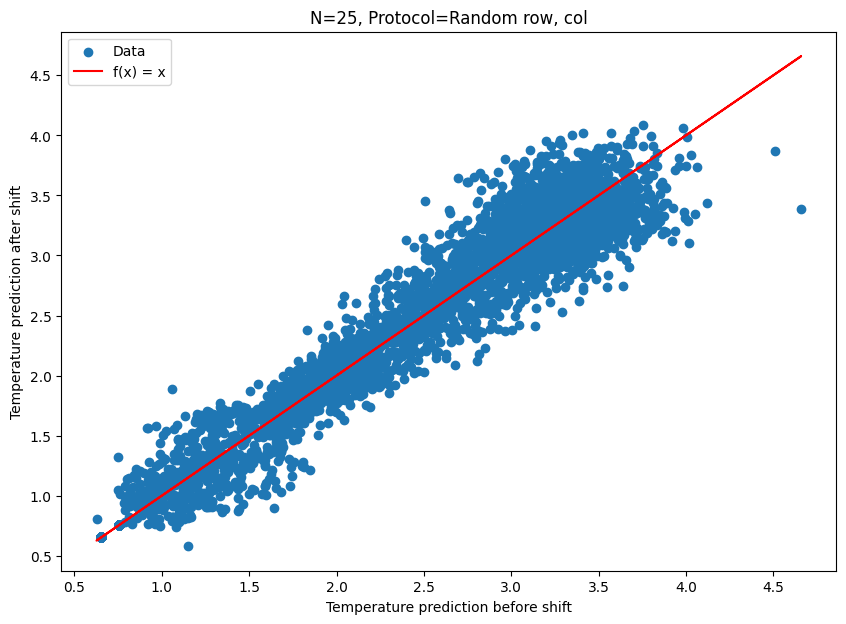

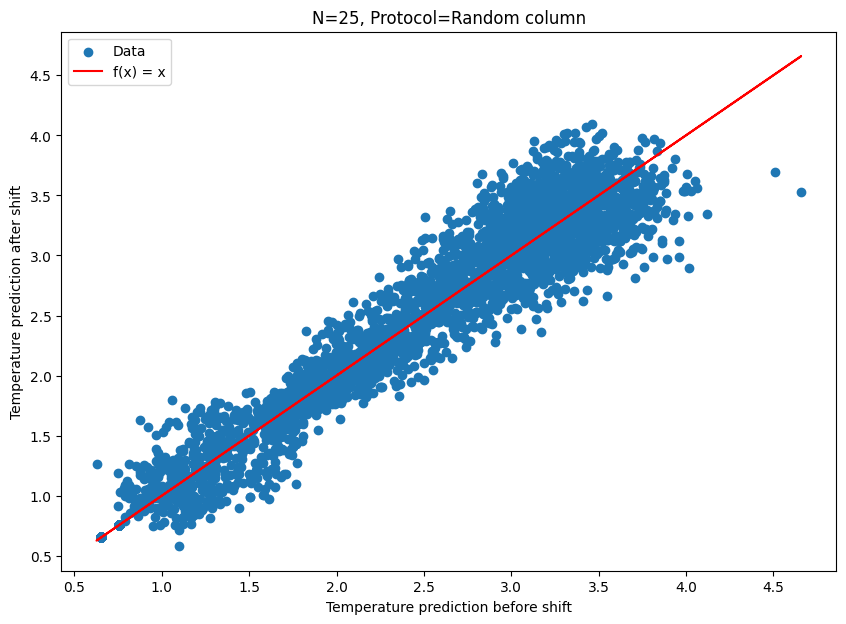

In [20]:
for model in models:
    print(f"------------- Test report for N={model.N} -------------")
    print("Protocol\t\tMean squared difference")
    print("")
    for protocol_name in protocols.keys():
        temp_before, temp_after = results[model.N][protocol_name][:, 0], results[model.N][protocol_name][:, 1]
        error = np.mean(np.power(temp_before - temp_after, 2))
        print(f"{protocol_name}\t\t{error}")
    print("")

for model in models:
    for protocol_name in protocols.keys():
        temp_before, temp_after = results[model.N][protocol_name][:, 0], results[model.N][protocol_name][:, 1]
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))

        ax.scatter(temp_before, temp_after, label="Data")
        ax.plot(temp_before, temp_before, color="red", label="f(x) = x")
        ax.set_xlabel("Temperature prediction before shift")
        ax.set_ylabel("Temperature prediction after shift")

        ax.legend()

        ax.set_title(f"N={model.N}, Protocol={protocol_name}")

        plt.show()

# After special training

In [3]:
# Load the new ML models into modles list
Ns = [10, 16, 25]
models = [IsingNNModel(N) for N in Ns]
for model in models:
    model.load_state_dict(torch.load(f"ising_nn_models_translation/N_{model.N}_J_1_B_0.pth"))
    model.eval()

In [4]:
protocols = {"Single row": protocol_single_row, "Single column": protocol_single_col, "Single row, col": protocol_single_row_col, 
            "Random row": protocol_random_row, "Random row, col": protocol_random_row_col, "Random column": protocol_random_col}
results = {N : {} for N in Ns}

total_jobs = len(protocols) * len(models)
done = 0

with torch.no_grad():
    for model in models:
        dataset = IsingDataset(train=False, N=model.N, J=1, B=0)
        for protocol_name, protocol in protocols.items():
            results[model.N][protocol_name] = np.empty((len(dataset), 2))
            for i, entry in enumerate(dataset):
                config, label = entry
                temp_pred_before = model(config)[0].item()
                config = shift_config(config, protocol)
                temp_pred_after = model(config)[0].item()
                results[model.N][protocol_name][i] = [temp_pred_before, temp_pred_after]
            done += 1
            print(f"Progress: {done/total_jobs*100:0.2f}%", end="\r")

------------- Test report for N=10 -------------
Protocol		Mean squared difference

Single row		0.0057047653194202295
Single column		0.0056452847196937685
Single row, col		0.005300513691753028
Random row		0.005188955823472165
Random row, col		0.005689045934525658
Random column		0.005017239995177499

------------- Test report for N=16 -------------
Protocol		Mean squared difference

Single row		0.01356031222144746
Single column		0.01452303134963907
Single row, col		0.015554075025391276
Random row		0.016363395342638434
Random row, col		0.01879873819868701
Random column		0.016394546805176113

------------- Test report for N=25 -------------
Protocol		Mean squared difference

Single row		0.01831638908726663
Single column		0.017880316980973567
Single row, col		0.019110963240000535
Random row		0.02086438332797984
Random row, col		0.022176097387412694
Random column		0.02099639247399022



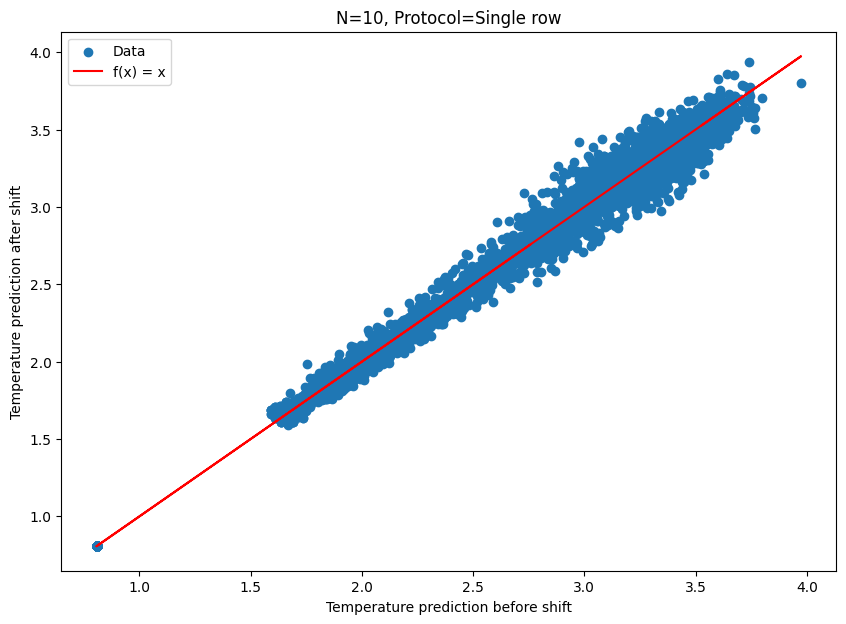

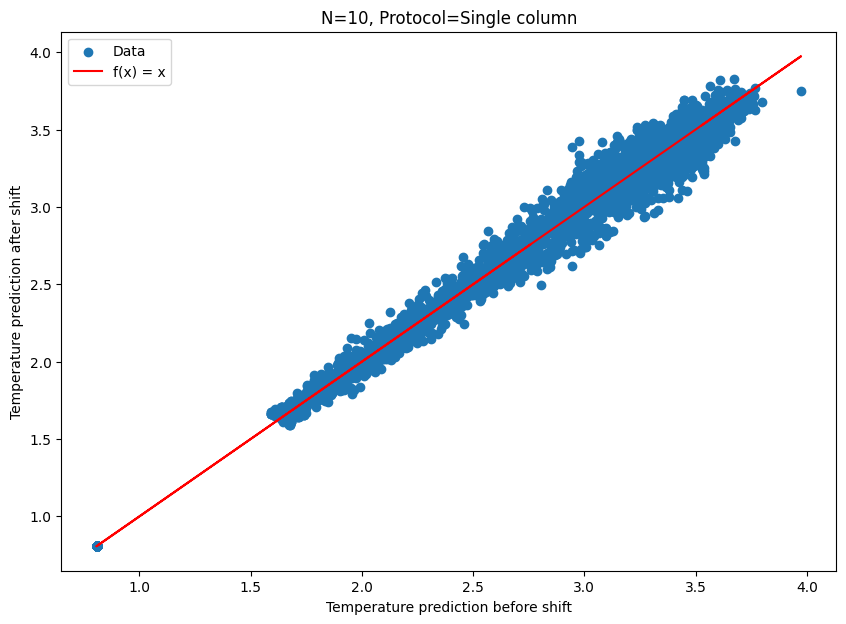

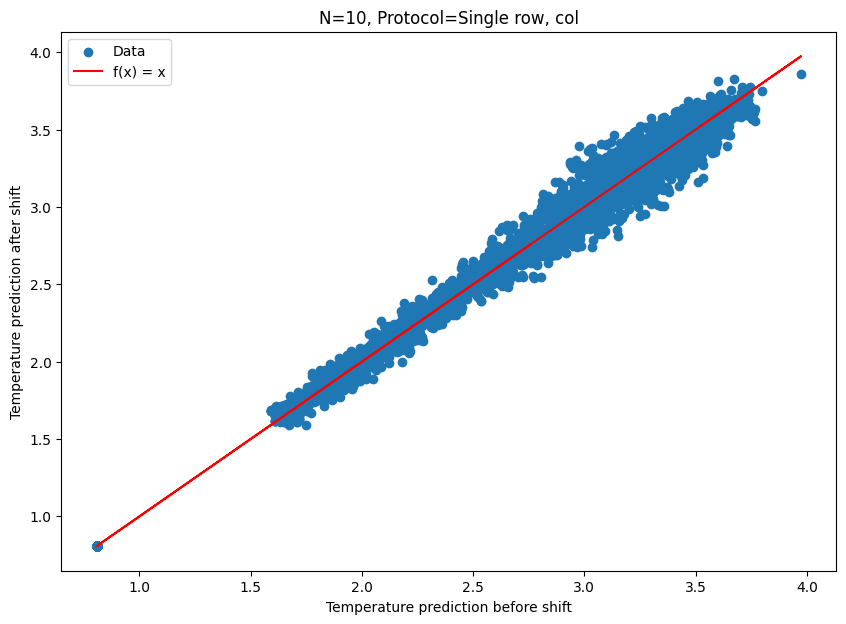

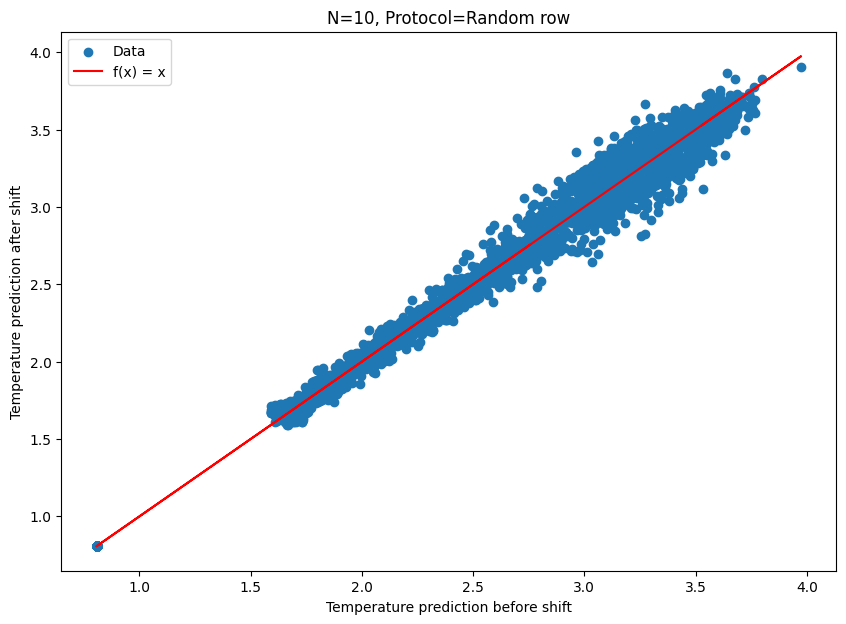

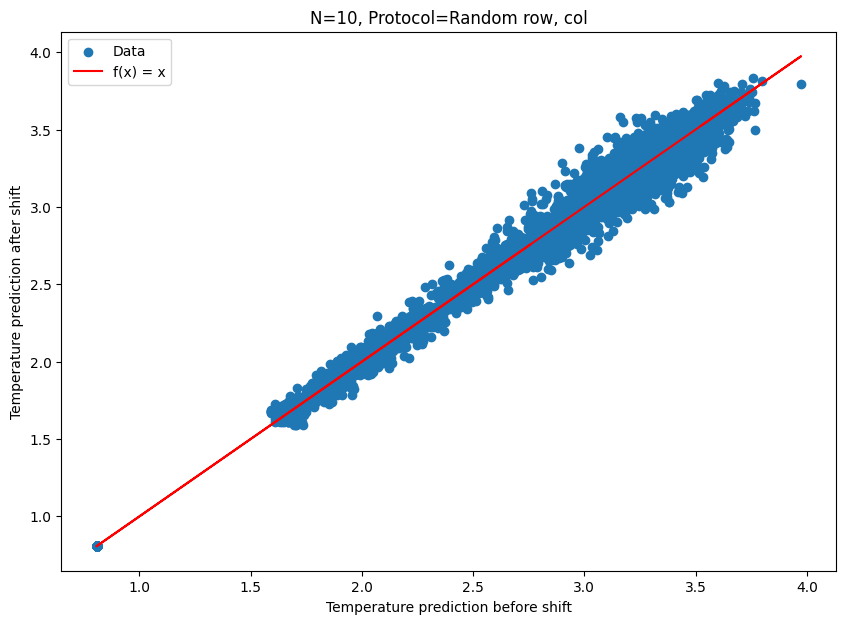

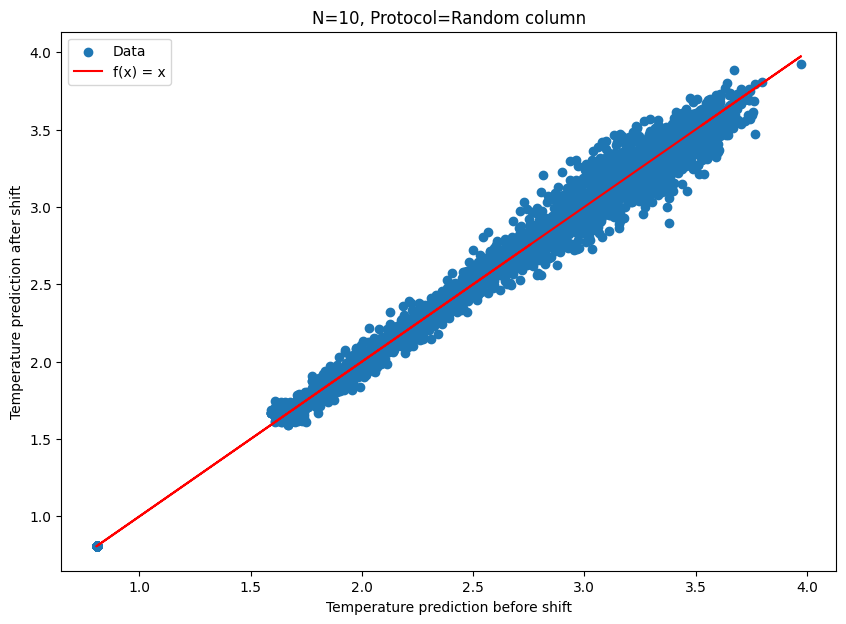

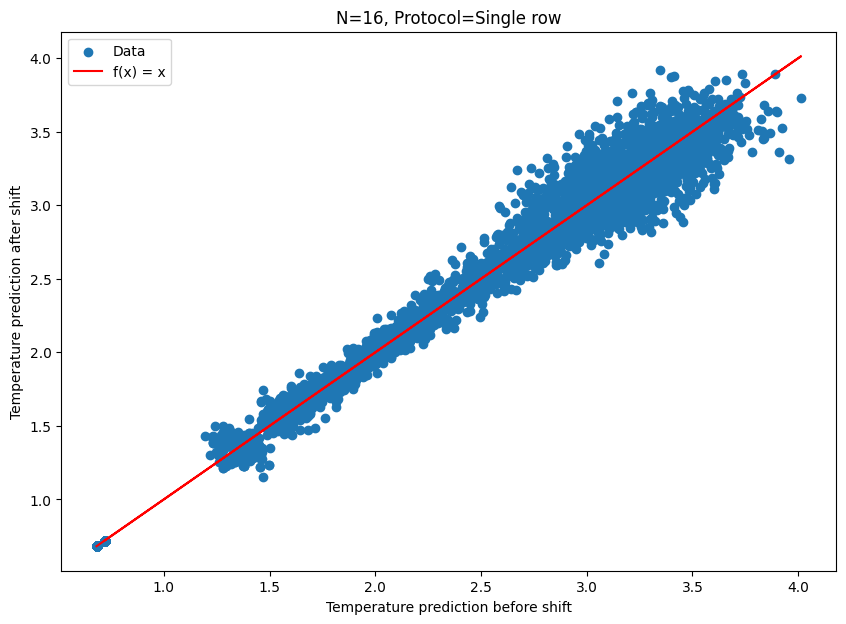

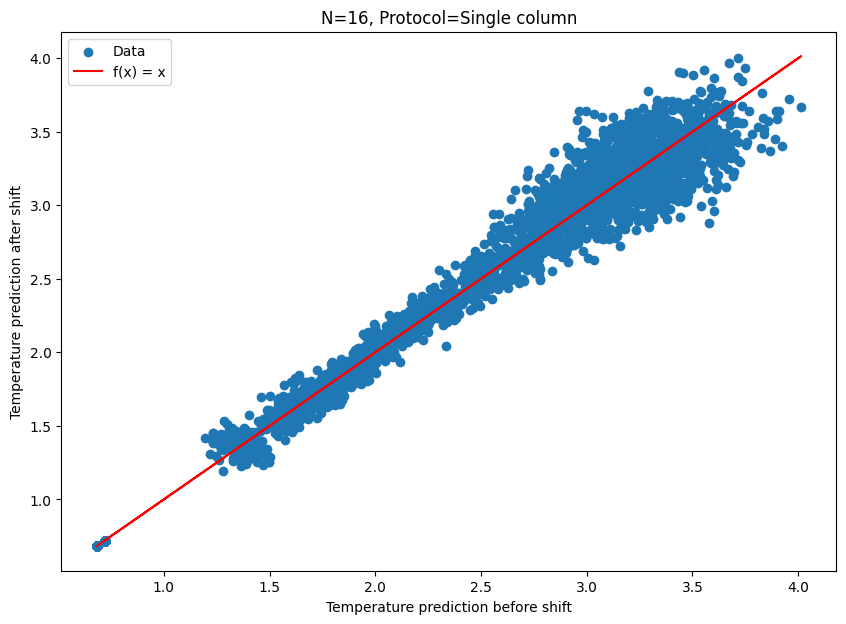

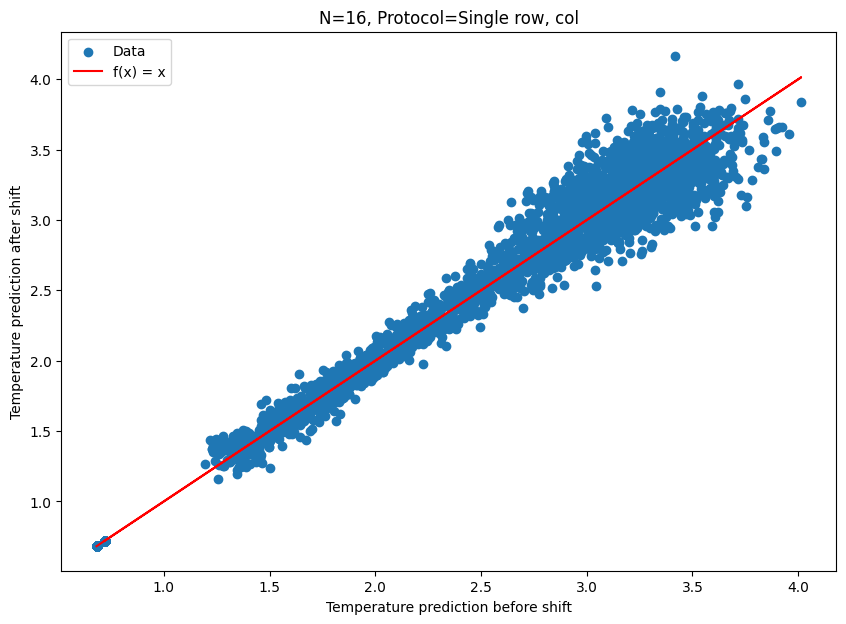

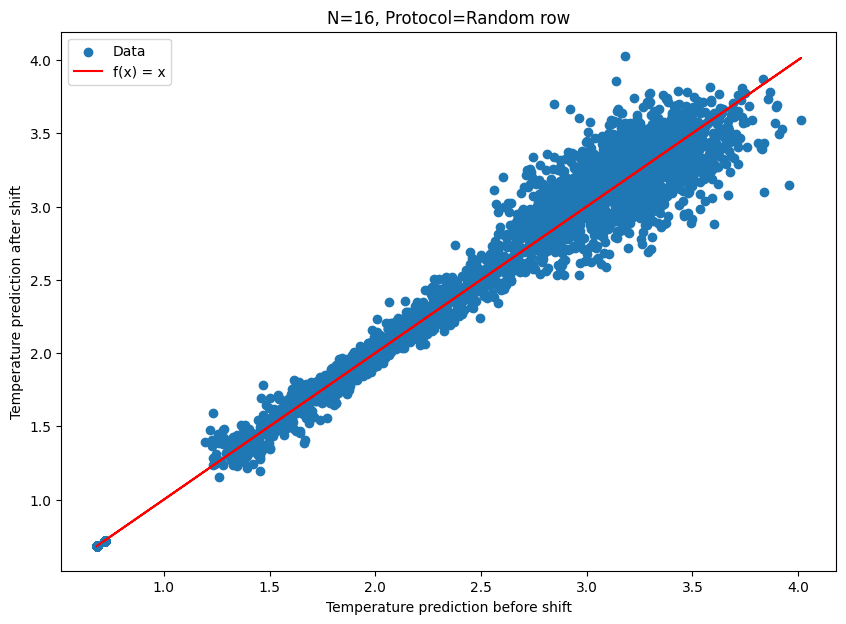

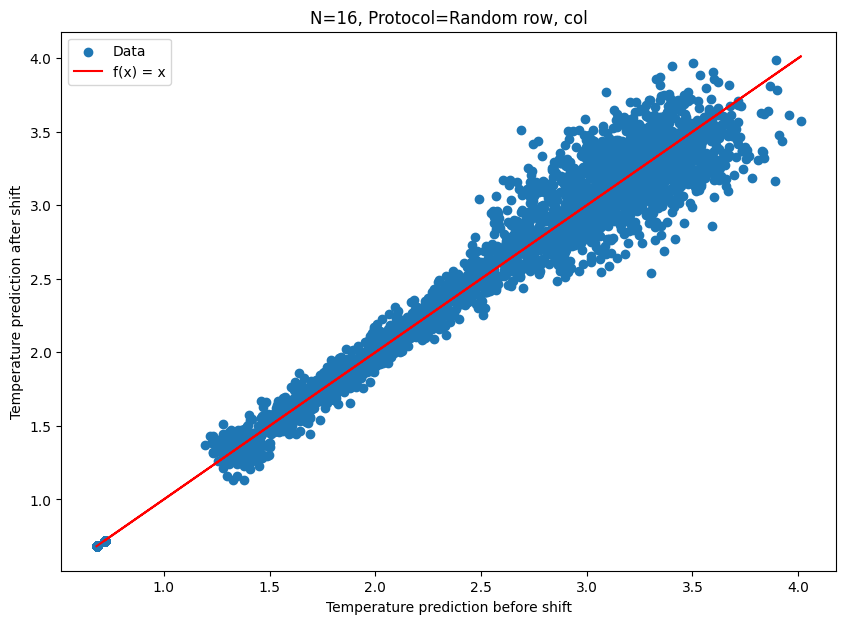

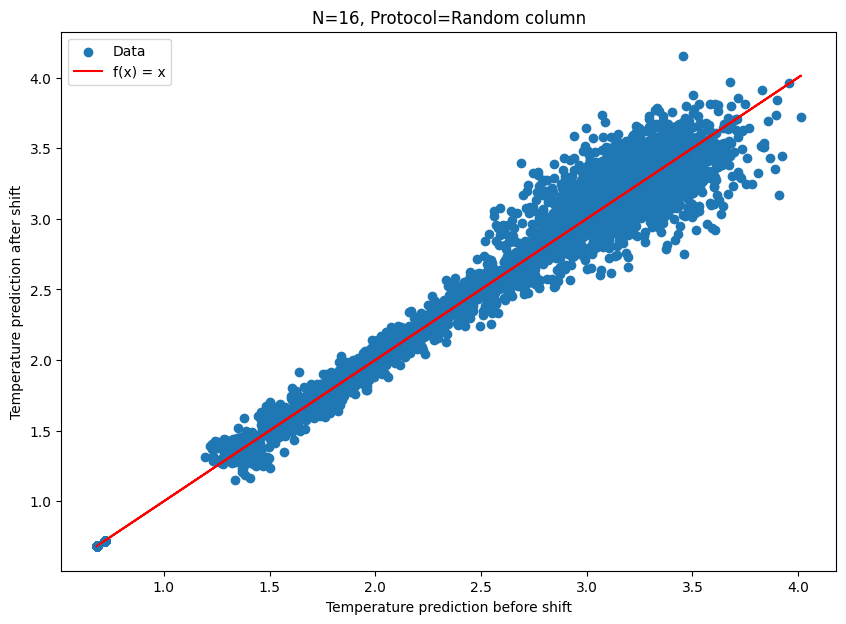

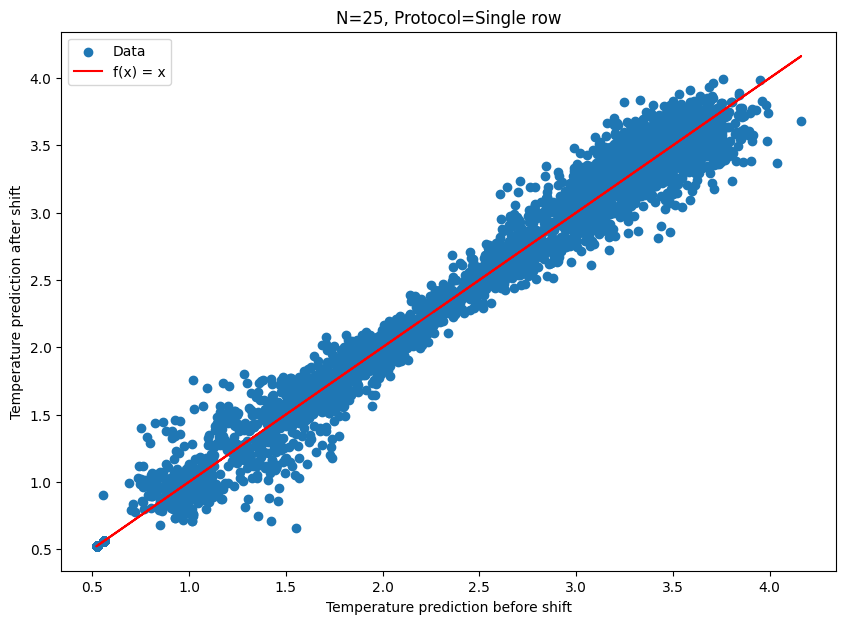

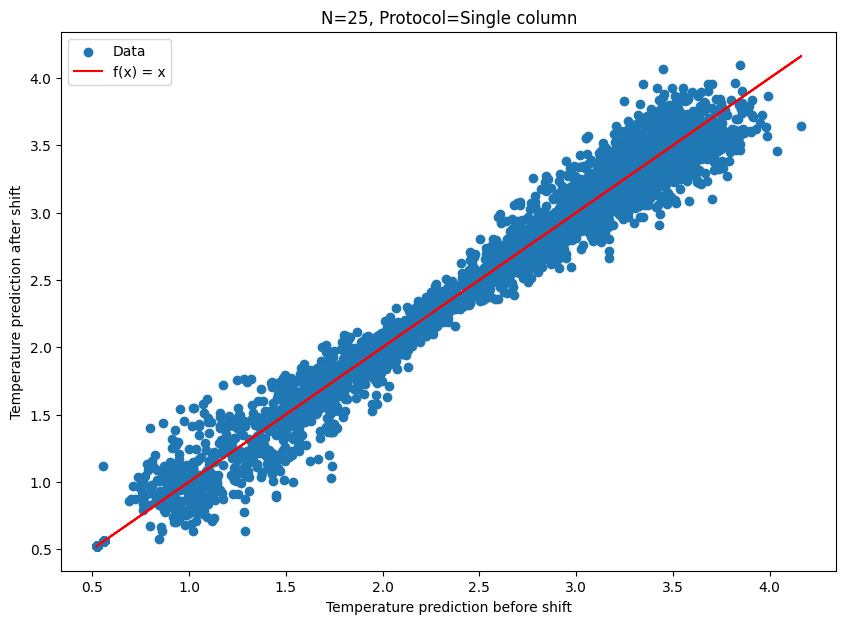

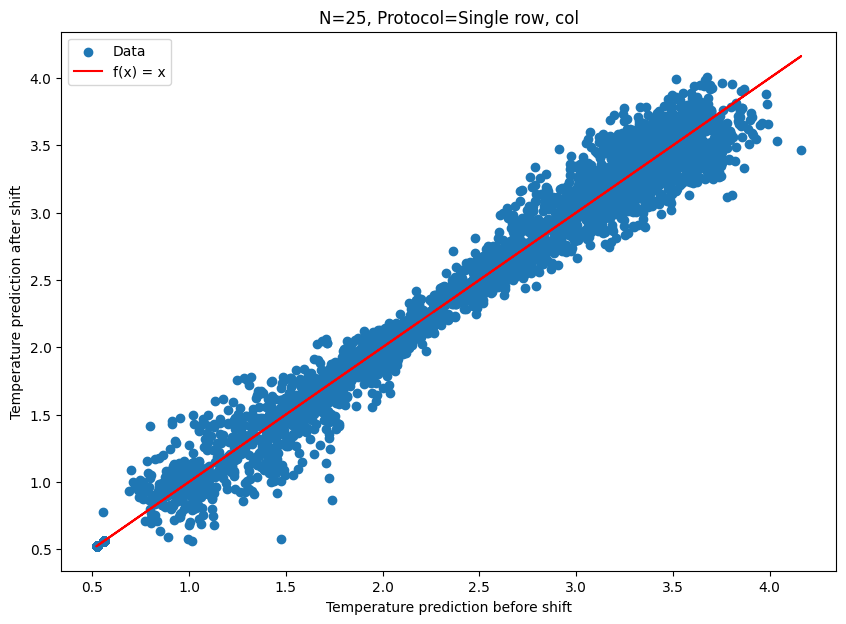

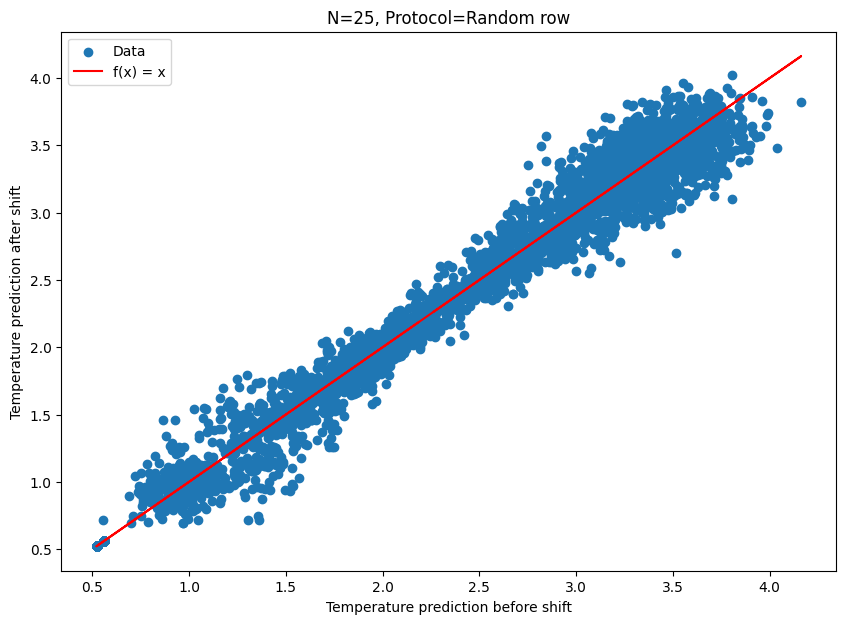

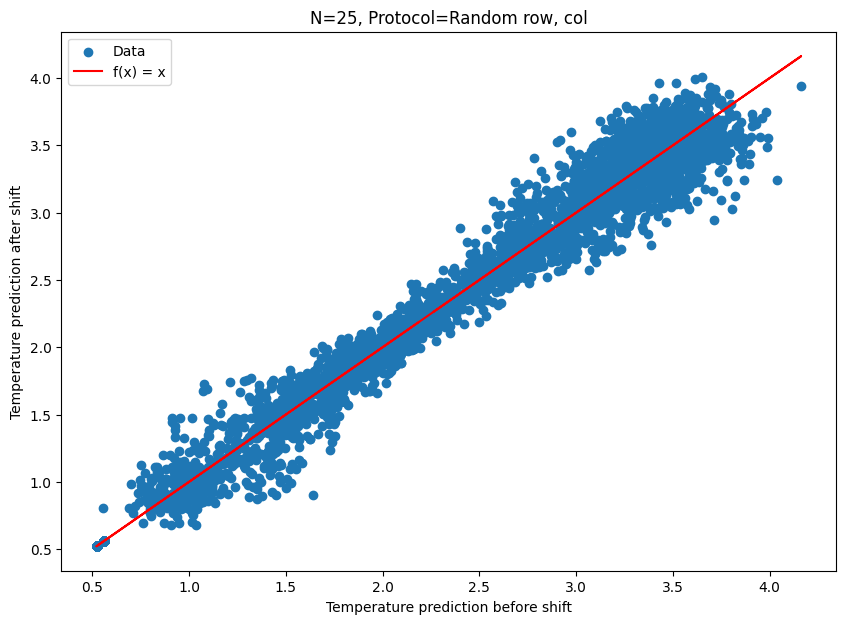

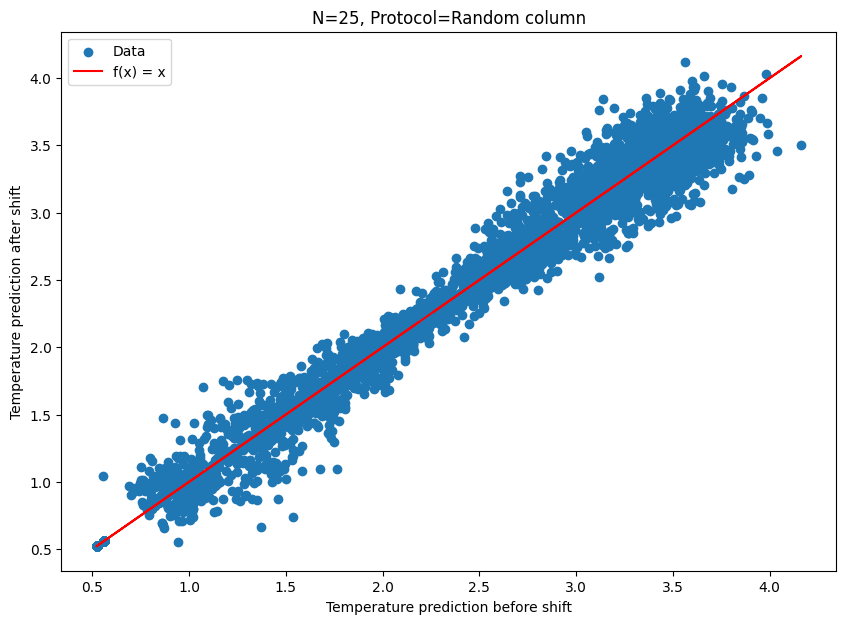

In [5]:
for model in models:
    print(f"------------- Test report for N={model.N} -------------")
    print("Protocol\t\tMean squared difference")
    print("")
    for protocol_name in protocols.keys():
        temp_before, temp_after = results[model.N][protocol_name][:, 0], results[model.N][protocol_name][:, 1]
        error = np.mean(np.power(temp_before - temp_after, 2))
        print(f"{protocol_name}\t\t{error}")
    print("")

for model in models:
    for protocol_name in protocols.keys():
        temp_before, temp_after = results[model.N][protocol_name][:, 0], results[model.N][protocol_name][:, 1]
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))

        ax.scatter(temp_before, temp_after, label="Data")
        ax.plot(temp_before, temp_before, color="red", label="f(x) = x")
        ax.set_xlabel("Temperature prediction before shift")
        ax.set_ylabel("Temperature prediction after shift")

        ax.legend()

        ax.set_title(f"N={model.N}, Protocol={protocol_name}")

        plt.show()